In [ ]:
import apriori_evaluation as ae
from utils import EventStream
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
stream_example = EventStream('../data/SmallExample.json', o2o_has_time=True)
stream_container_logistics = EventStream('../data/ContainerLogistics.json')
stream_age_of_empires = EventStream('../data/AgeOfEmpires10Matches.json')

Parsing ../data/SmallExample.json...
# of (removed) E2O target objects w/o type: 0
# of (removed) O2O target objects w/o type: 0
# events:			5
# object updates:		0
# O2O relations:		1
# E2O-derived O2O relations:	11
Enriching enabled: False
Finished parsing ../data/SmallExample.json in 0.00 min.
Parsing ../data/ContainerLogistics.json...
# of (removed) E2O target objects w/o type: 31
# of (removed) O2O target objects w/o type: 6
# events:			35413
# object updates:		13052
# O2O relations:		15926
# E2O-derived O2O relations:	74272
Enriching enabled: False
Finished parsing ../data/ContainerLogistics.json in 0.29 min.
Parsing ../data/AgeOfEmpires10Matches.json...
# of (removed) E2O target objects w/o type: 0
# of (removed) O2O target objects w/o type: 0
# events:			34860
# object updates:		0
# O2O relations:		33407
# E2O-derived O2O relations:	149522
Enriching enabled: False
Finished parsing ../data/AgeOfEmpires10Matches.json in 0.21 min.


### EventStream composition

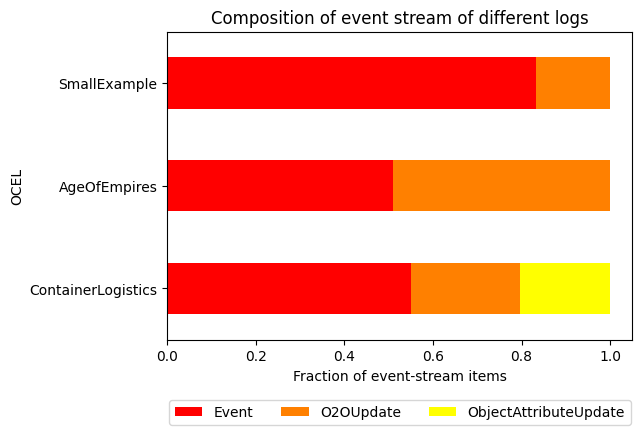

In [4]:
_, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Composition of event stream of different logs')

df_dict = {'Event': list(), 'O2OUpdate': list(), 'ObjectAttributeUpdate': list()}
df_index = list()
item_colors = cm.autumn(np.linspace(0, 1, len(df_dict.keys())))
item_to_color = dict(zip(df_dict.keys(), item_colors))

for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    df_index.append(stream_name)
    stream_size = len(stream.stream)
    df_dict['Event'].append(len(stream.events)/stream_size)
    df_dict['O2OUpdate'].append(len(stream.o2o_updates)/stream_size)
    df_dict['ObjectAttributeUpdate'].append(len(stream.object_updates)/stream_size)

df = pd.DataFrame(df_dict, index=df_index)
df.plot(kind='barh', stacked=True, ax=ax, color=item_to_color)
ax.set_ylabel('OCEL')
ax.set_xlabel('Fraction of event-stream items')
ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3))

In [6]:
stream_example = stream_example.stream
stream_container_logistics = stream_container_logistics.stream
stream_age_of_empires = stream_age_of_empires.stream

AttributeError: 'list' object has no attribute 'stream'

### Percentage per object type across entire EventStream

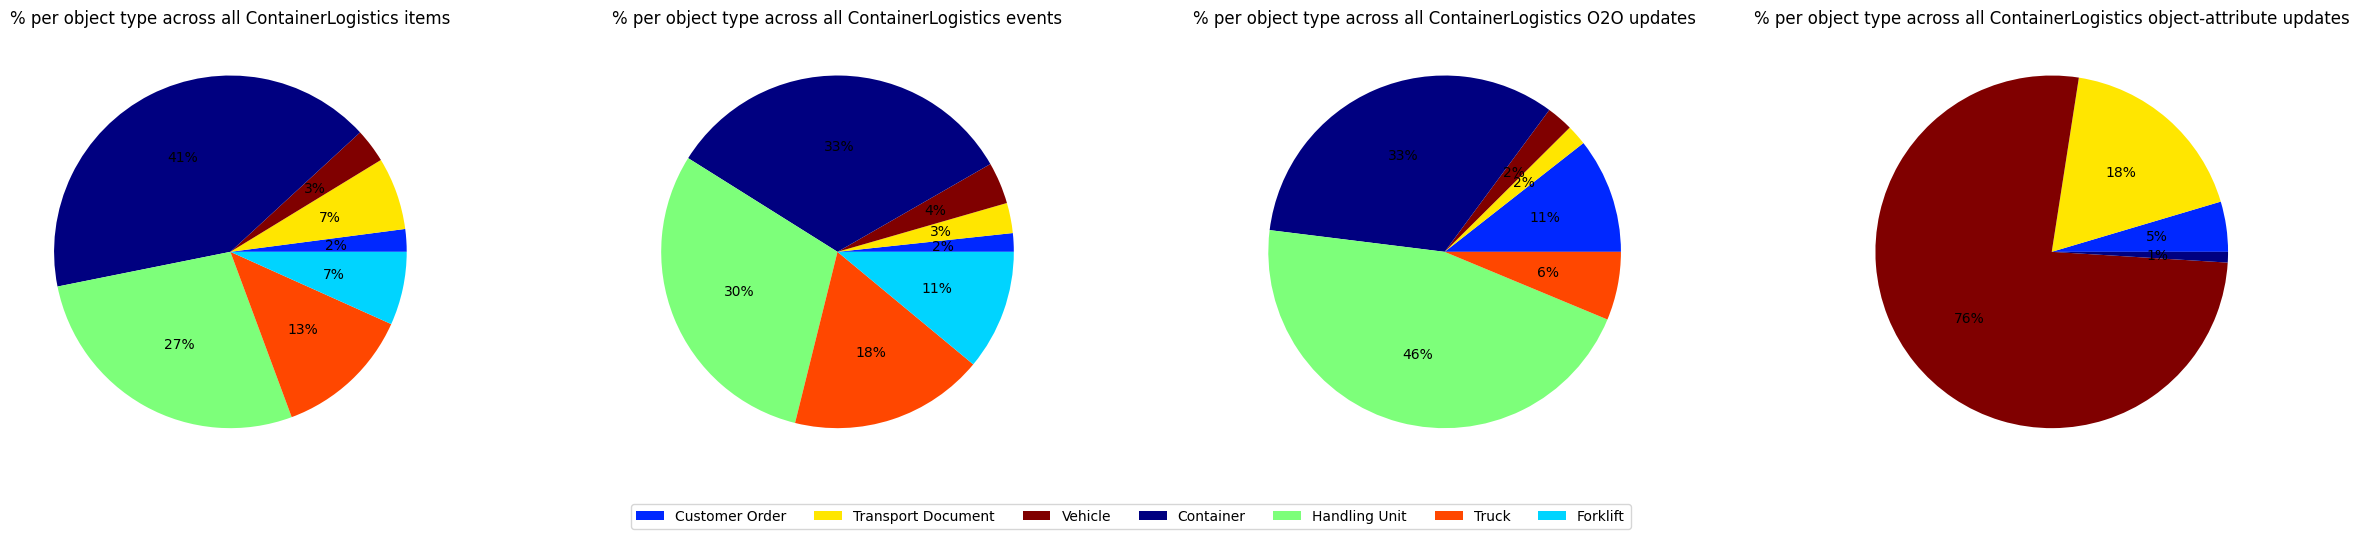

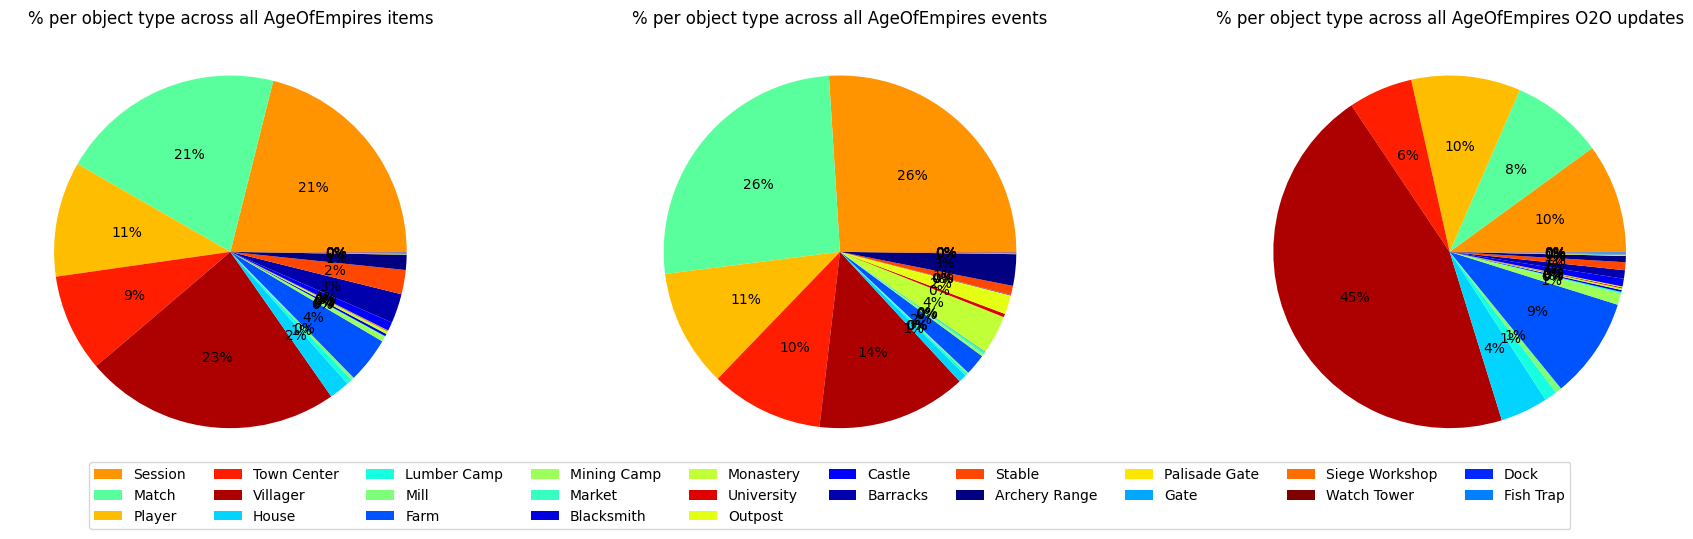

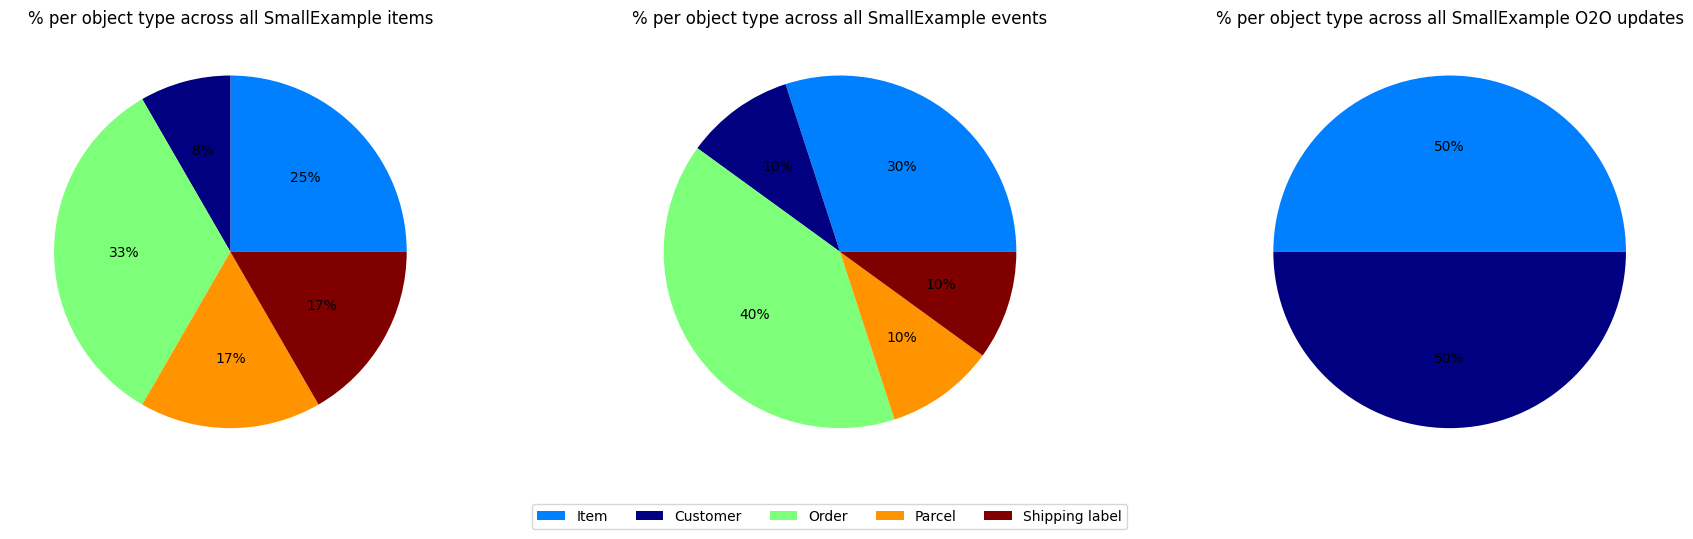

In [9]:
for i, (stream_name, stream, num_ax) in enumerate([
    ('ContainerLogistics', stream_container_logistics, 4),
    ('AgeOfEmpires', stream_age_of_empires, 3),
    ('SmallExample', stream_example, 3)
    ]):
    fig, axs = plt.subplots(1, num_ax, figsize=(6*num_ax, 5))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.6, wspace=0.2)

    ot_freq_total, ot_freq_event, ot_freq_o2o, ot_freq_oau = ae.get_ot_frac_across_stream(stream)
    ots = sorted(ot_freq_total)
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))
    ot_to_hex_color = {ot: mpl.colors.rgb2hex(ot_rgb) for ot, ot_rgb in ot_to_rgb_color.items()}

    plt.sca(axs[0])
    plt.title(f'% per object type across all {stream_name} items')
    plt.pie(ot_freq_total.values(), labels=None, autopct='%1.0f%%', colors=[ot_to_hex_color[ot] for ot in ot_freq_total])

    plt.sca(axs[1])
    plt.title(f'% per object type across all {stream_name} events')
    plt.pie(ot_freq_event.values(), labels=None, autopct='%1.0f%%', colors=[ot_to_hex_color[ot] for ot in ot_freq_total])

    if num_ax > 2:
        plt.sca(axs[2])
        plt.title(f'% per object type across all {stream_name} O2O updates')
        plt.pie(ot_freq_o2o.values(), labels=None, autopct='%1.0f%%', colors=[ot_to_hex_color[ot] for ot in ot_freq_total])

    if num_ax > 3:
        plt.sca(axs[3])
        plt.title(f'% per object type across all {stream_name} object-attribute updates')
        plt.pie(ot_freq_oau.values(), labels=None, autopct='%1.0f%%', colors=[ot_to_hex_color[ot] for ot in ot_freq_total])
    
    fig.legend(labels=ot_freq_total.keys(), loc='lower center', ncol=10, bbox_to_anchor=(0.5, -0.05))

### Number of objects per event per object type

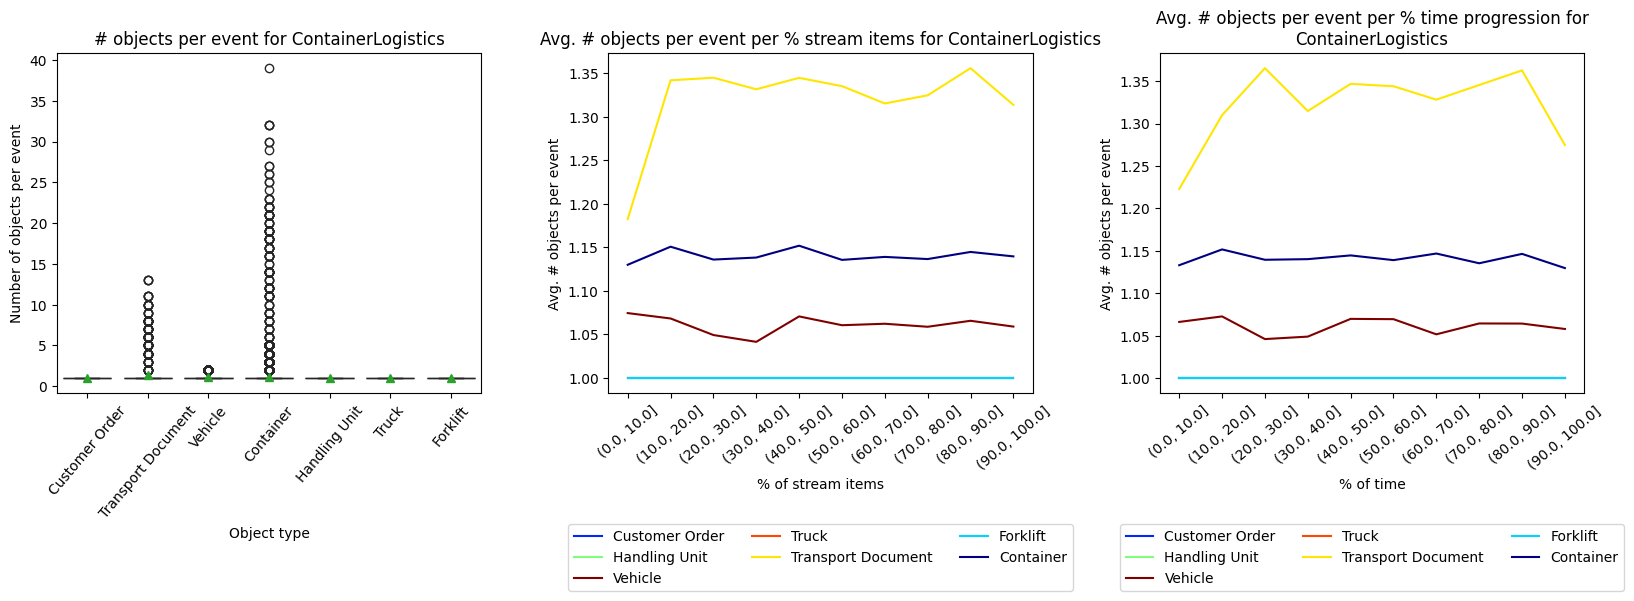

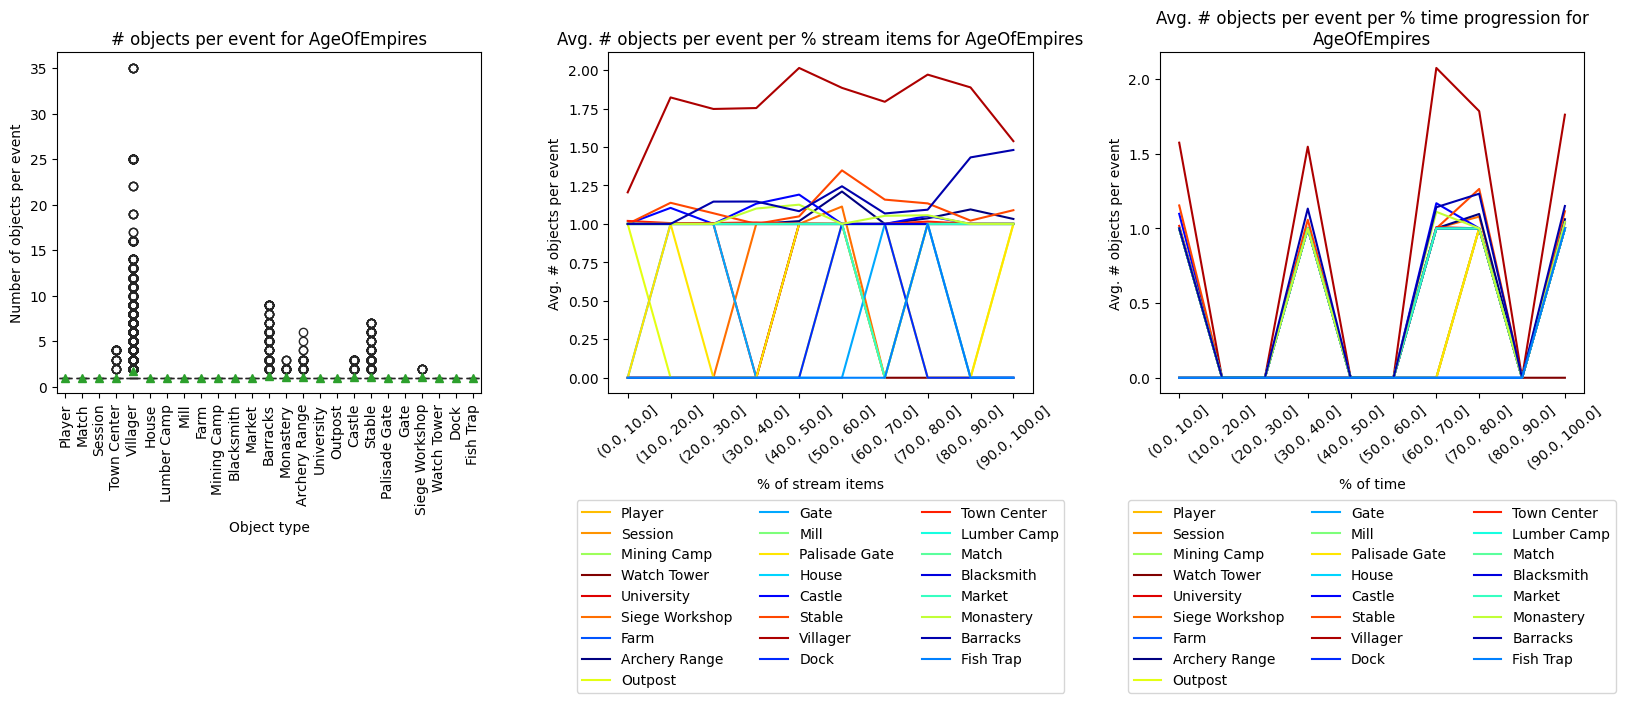

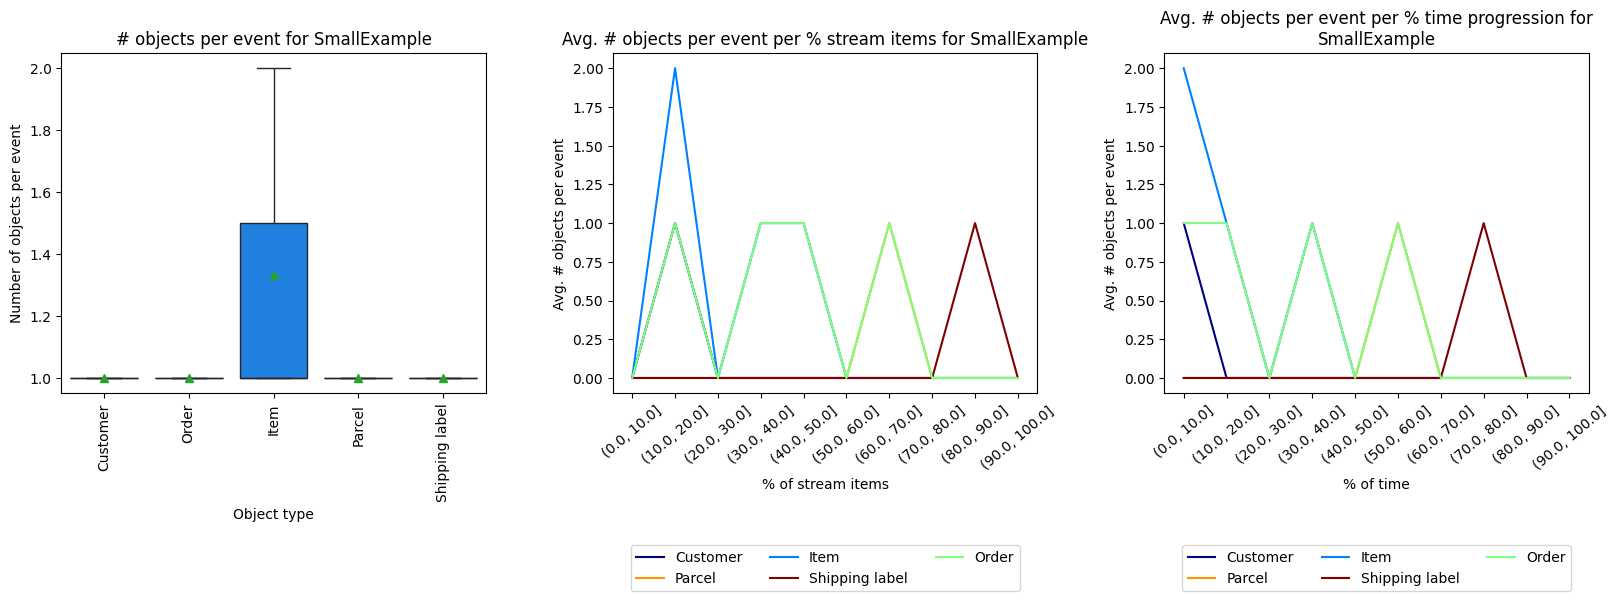

In [19]:
for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.3)

    ot_dict, res_dict, res_dict_per_stream_fraction, res_dict_per_time_fraction = ae.get_num_obj_per_event_per_ot(stream)
    ots = sorted(ot_dict.keys())
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))

    # Create boxplot to show distribution across entire stream per OT side by side
    sns.boxplot(ot_dict, ax=axs[0], palette=ot_to_rgb_color, showmeans=True)
    axs[0].set_title(f'# objects per event for {stream_name}')
    axs[0].tick_params(axis='x', rotation=50 if stream_name == 'ContainerLogistics' else 90)
    axs[0].set_xlabel('Object type')
    axs[0].set_ylabel('Number of objects per event')

    # Create lineplot of change of average per object type depending on % of seen stream items
    df_stream_frac = pd.DataFrame.from_dict(res_dict_per_stream_fraction, orient='index').reset_index()
    df_stream_frac = df_stream_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_stream_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[1])
    axs[1].set_title(f'Avg. # objects per event per % stream items for {stream_name}')
    axs[1].tick_params(axis='x', rotation=40)
    axs[1].set_xlabel('% of stream items')
    axs[1].set_ylabel('Avg. # objects per event')
    axs[1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

    # Create lineplot of change of average per object type depending on time progression
    df_time_frac = pd.DataFrame.from_dict(res_dict_per_time_fraction, orient='index').reset_index()
    df_time_frac = df_time_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_time_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[2])
    axs[2].set_title(f'Avg. # objects per event per % time progression for\n{stream_name}')
    axs[2].tick_params(axis='x', rotation=40)
    axs[2].set_xlabel('% of time')
    axs[2].set_ylabel('Avg. # objects per event')
    axs[2].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

### Number of unique object occurrences per object type

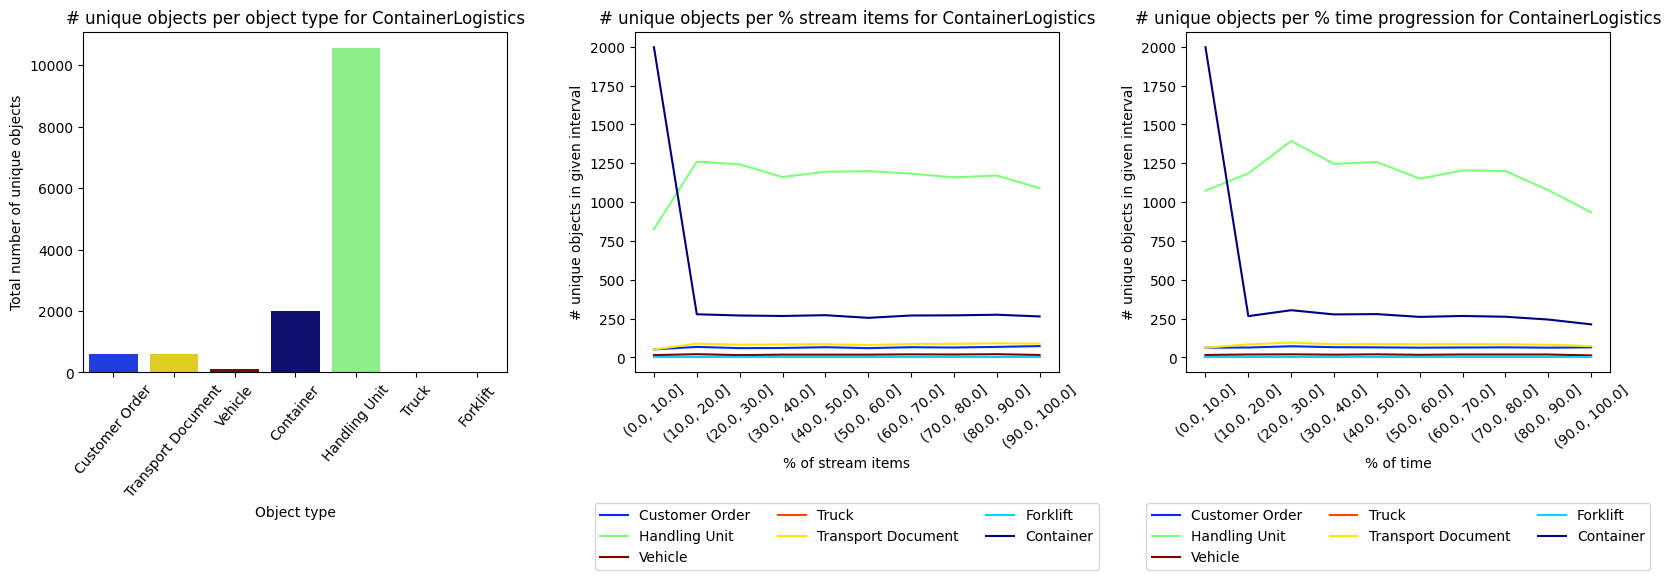

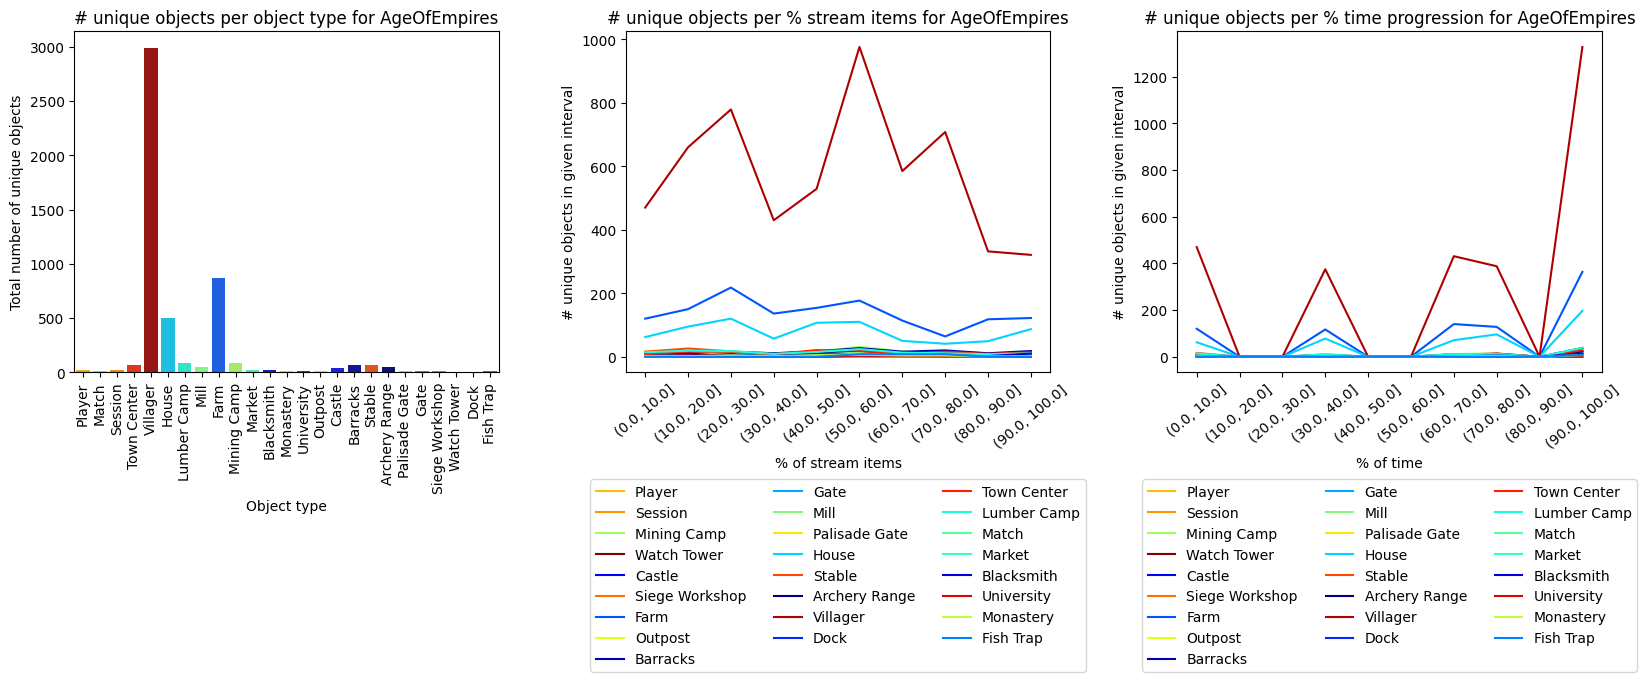

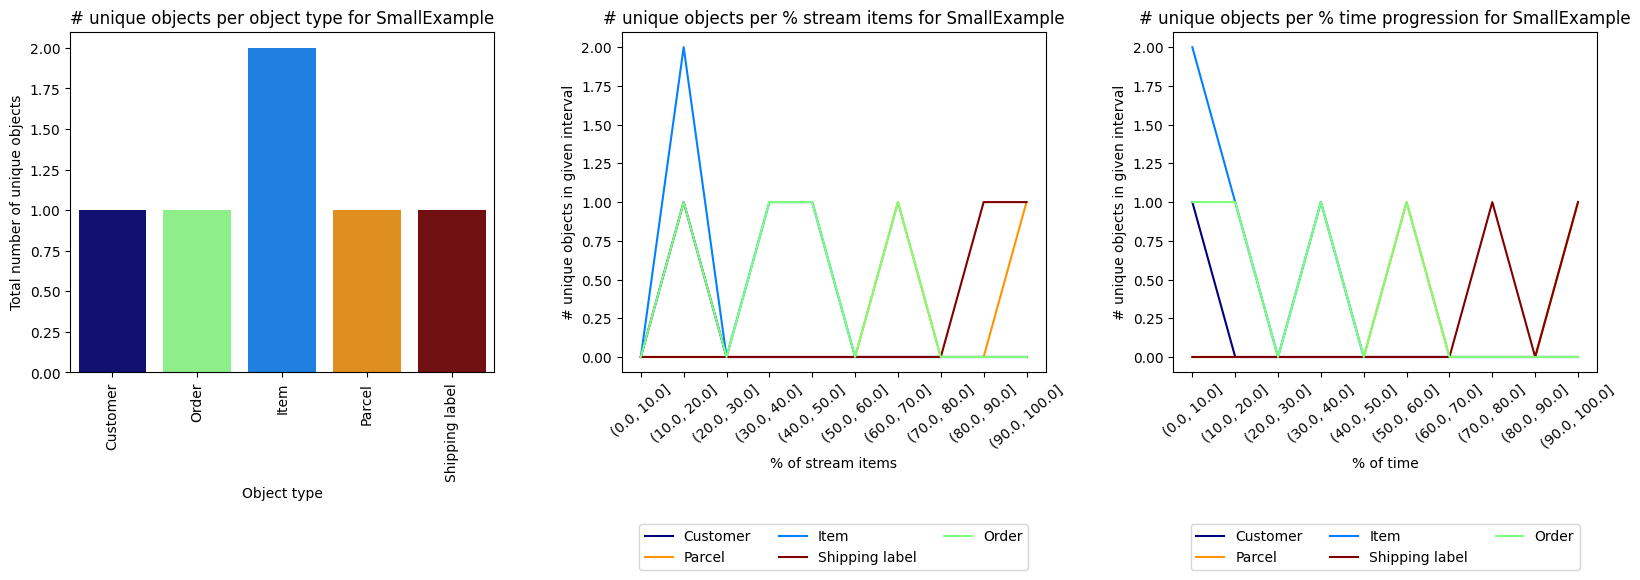

In [20]:
for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.3)

    res_dict, res_dict_per_stream_fraction, res_dict_per_time_fraction = ae.get_num_obj_per_ot(stream)
    
    ots = sorted(res_dict.keys())
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))

    # Create barplot to show distribution across entire stream per OT side by side
    sns.barplot(x=res_dict.keys(), y=res_dict.values(), hue=res_dict.keys(), palette=ot_to_rgb_color, ax=axs[0])
    axs[0].set_title(f'# unique objects per object type for {stream_name}')
    axs[0].tick_params(axis='x', rotation=50 if stream_name == 'ContainerLogistics' else 90)
    axs[0].set_xlabel('Object type')
    axs[0].set_ylabel('Total number of unique objects')

    # Create lineplot of change of # unique objects per OT depending on % of seen stream items
    df_stream_frac = pd.DataFrame.from_dict(res_dict_per_stream_fraction, orient='index').reset_index()
    df_stream_frac = df_stream_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_stream_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[1])
    axs[1].set_title(f'# unique objects per % stream items for {stream_name}')
    axs[1].tick_params(axis='x', rotation=40)
    axs[1].set_xlabel('% of stream items')
    axs[1].set_ylabel('# unique objects in given interval')
    axs[1].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

    # Create lineplot of change of # unique objects per OT depending on time progression
    df_time_frac = pd.DataFrame.from_dict(res_dict_per_time_fraction, orient='index').reset_index()
    df_time_frac = df_time_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_time_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[2])
    axs[2].set_title(f'# unique objects per % time progression for {stream_name}')
    axs[2].tick_params(axis='x', rotation=40)
    axs[2].set_xlabel('% of time')
    axs[2].set_ylabel('# unique objects in given interval')
    axs[2].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

### Number of events per object type

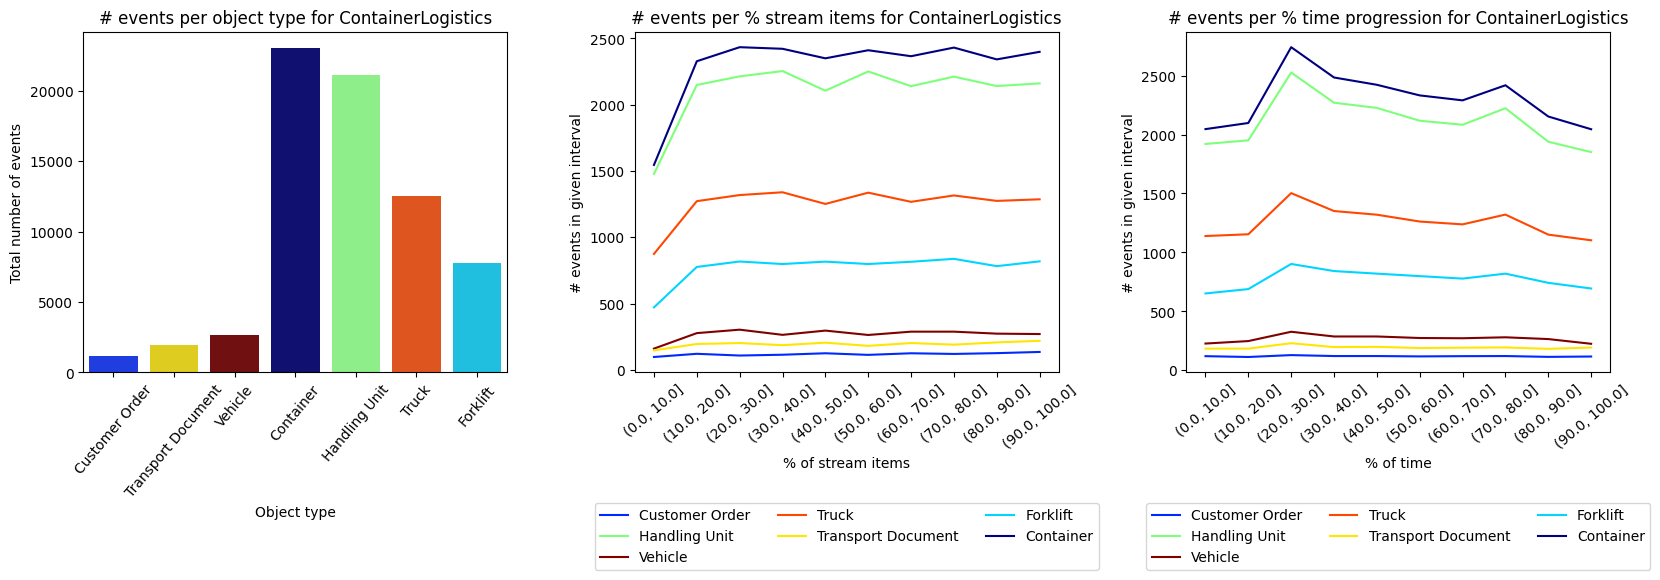

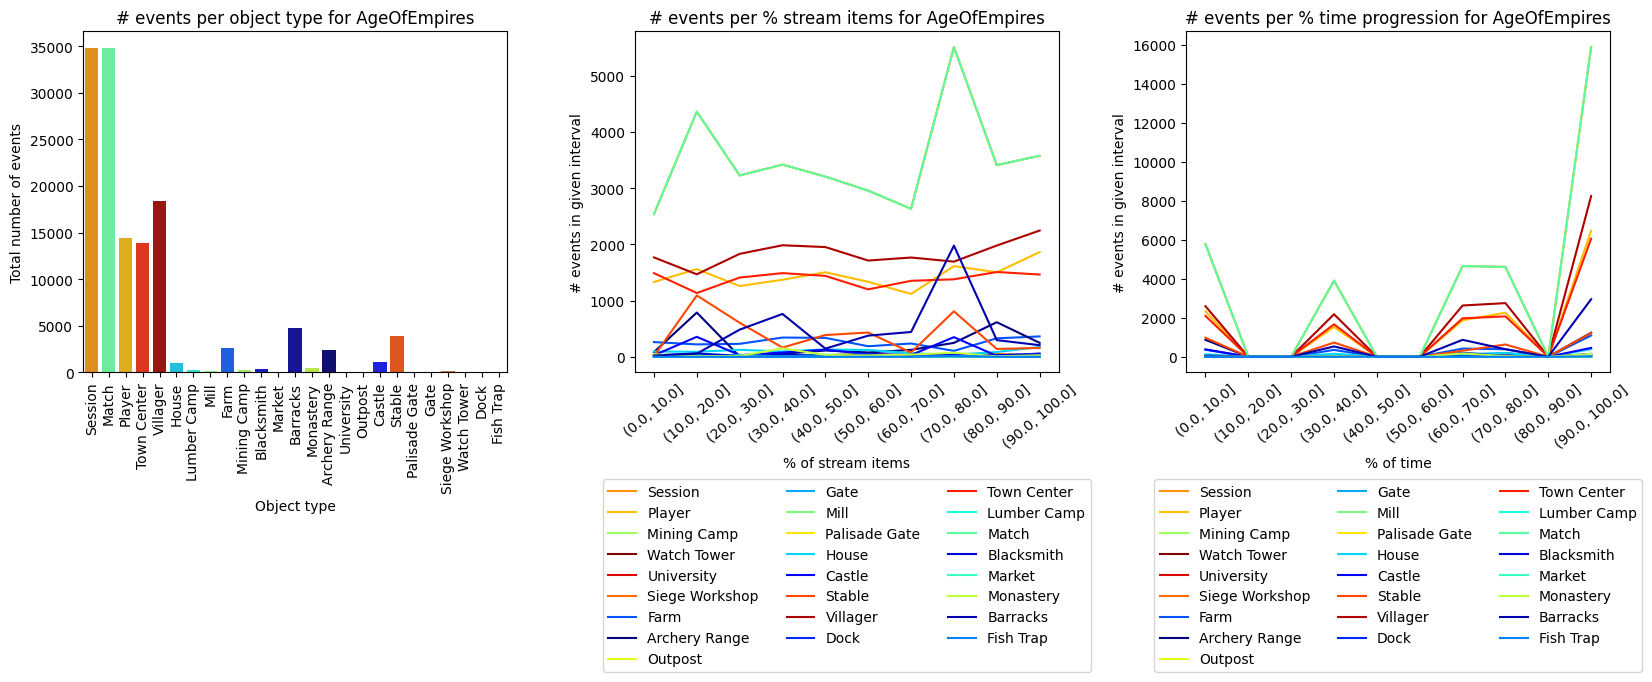

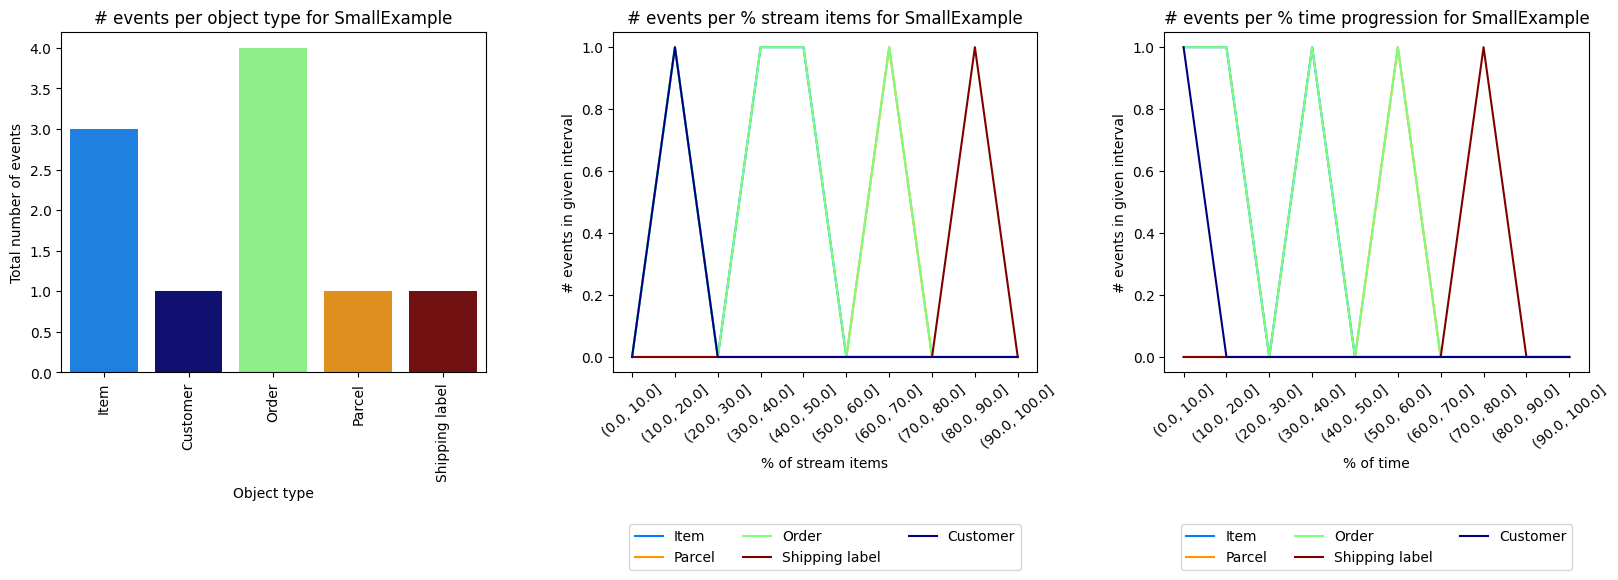

In [21]:
for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.3)

    res_dict, res_dict_per_stream_fraction, res_dict_per_time_fraction = ae.get_num_events_per_ot(stream)

    ots = sorted(res_dict.keys())
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))
    
    # Create barplot to show distribution across entire stream per OT side by side
    sns.barplot(x=res_dict.keys(), y=res_dict.values(), hue=res_dict.keys(), palette=ot_to_rgb_color, ax=axs[0])
    axs[0].set_title(f'# events per object type for {stream_name}')
    axs[0].tick_params(axis='x', rotation=50 if stream_name == 'ContainerLogistics' else 90)
    axs[0].set_xlabel('Object type')
    axs[0].set_ylabel('Total number of events')

    # Create lineplot of change of # events per OT depending on % of seen stream items
    df_stream_frac = pd.DataFrame.from_dict(res_dict_per_stream_fraction, orient='index').reset_index()
    df_stream_frac = df_stream_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_stream_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[1])
    axs[1].set_title(f'# events per % stream items for {stream_name}')
    axs[1].tick_params(axis='x', rotation=40)
    axs[1].set_xlabel('% of stream items')
    axs[1].set_ylabel('# events in given interval')
    axs[1].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

    # Create lineplot of change of # events per OT depending on time progression
    df_time_frac = pd.DataFrame.from_dict(res_dict_per_time_fraction, orient='index').reset_index()
    df_time_frac = df_time_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_time_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[2])
    axs[2].set_title(f'# events per % time progression for {stream_name}')
    axs[2].tick_params(axis='x', rotation=40)
    axs[2].set_xlabel('% of time')
    axs[2].set_ylabel('# events in given interval')
    axs[2].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

### Avg. time between object re-occurences in events ("re-use stride") per object type

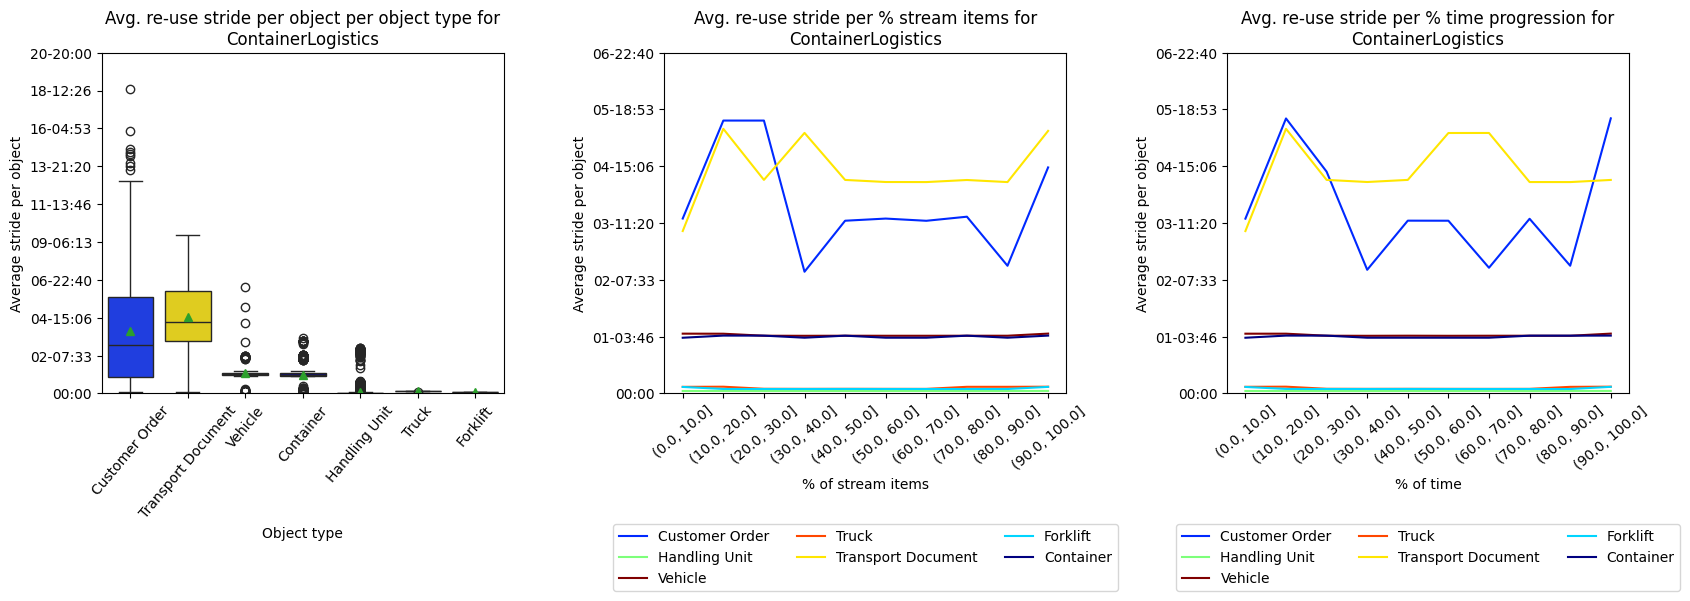

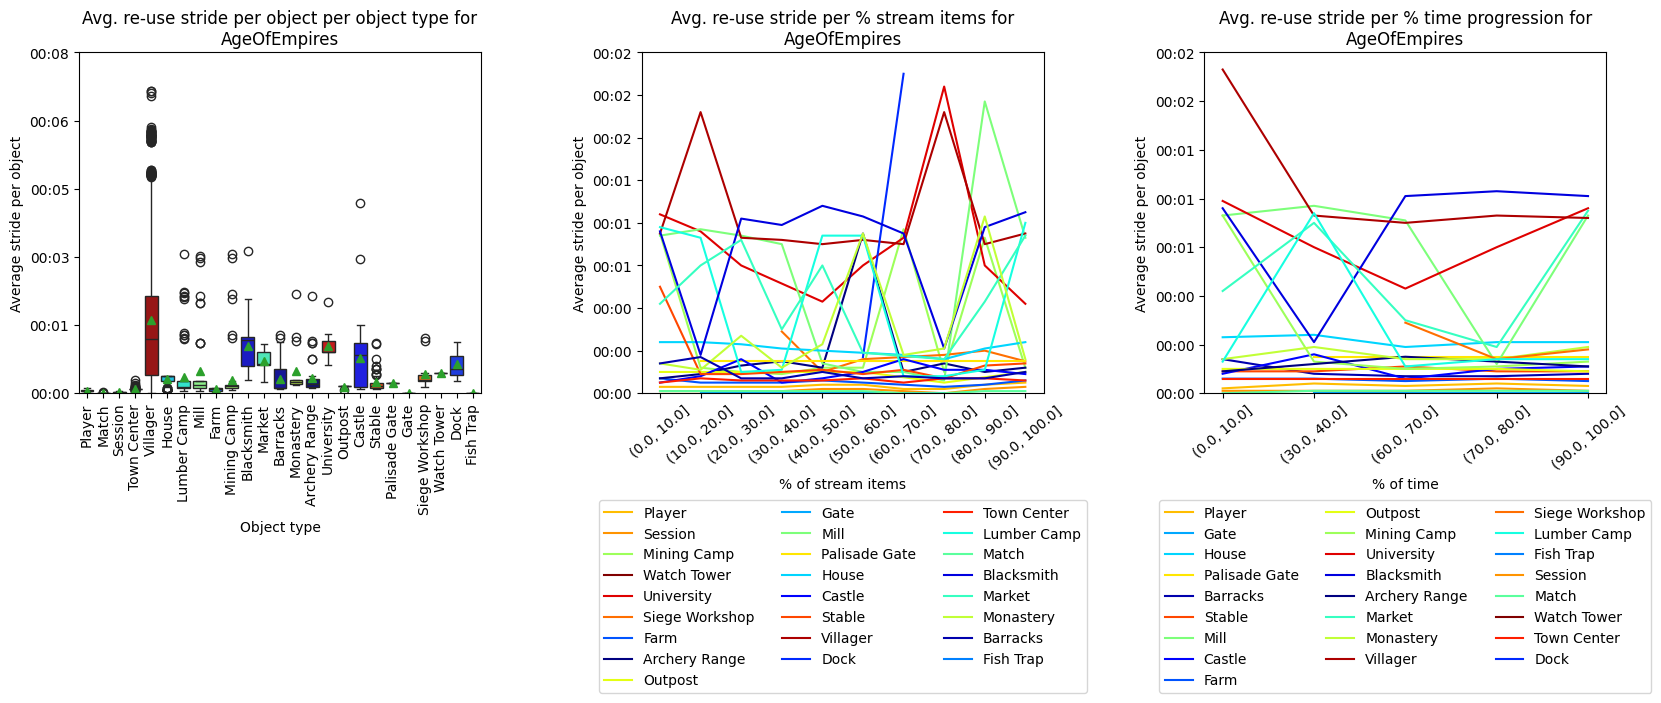

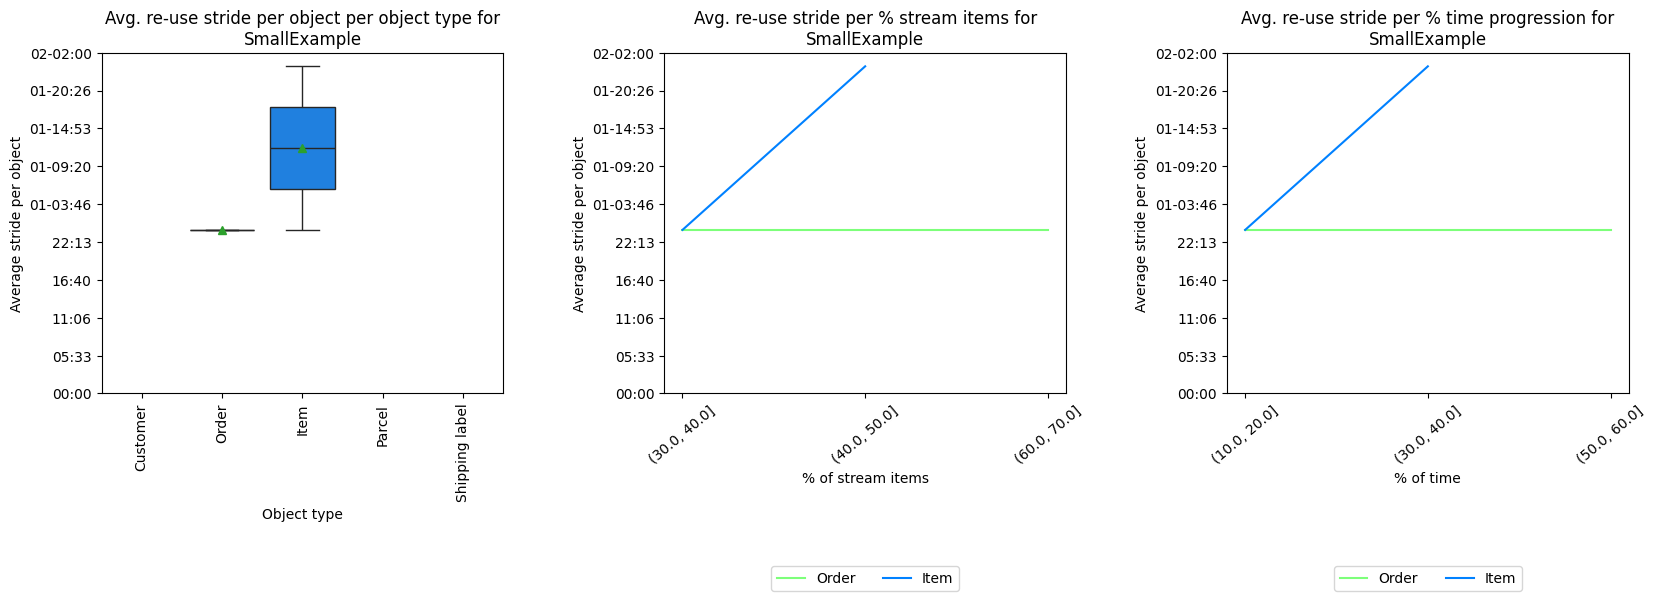

In [23]:
for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.4)

    avg_per_obj, _, ot_avg_per_stream_fraction, ot_avg_per_time_fraction = ae.get_reuse_stride(stream)

    ots = sorted(avg_per_obj.keys())
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))

    # Create boxplot to show distribution across entire stream per OT side by side
    sns.boxplot(avg_per_obj, palette=ot_to_rgb_color, ax=axs[0], showmeans=True)
    axs[0].set_title(f'Avg. re-use stride per object per object type for\n{stream_name}')
    axs[0].tick_params(axis='x', rotation=50 if stream_name == 'ContainerLogistics' else 90)
    axs[0].set_ylim(ymin=0)
    axs[0].set_yticks(axs[0].get_yticks())
    axs[0].set_yticklabels([ae.seconds_to_td_str(float(xtl.get_unitless_position()[1])) for xtl in axs[0].get_yticklabels()])
    axs[0].set_xlabel('Object type')
    axs[0].set_ylabel('Average stride per object')

    # Create lineplot of change of avg. object-occurence stride per OT depending on % of seen stream items
    df_stream_frac = pd.DataFrame.from_dict(ot_avg_per_stream_fraction, orient='index').reset_index()
    df_stream_frac = df_stream_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_stream_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[1])
    axs[1].set_title(f'Avg. re-use stride per % stream items for\n{stream_name}')
    axs[1].tick_params(axis='x', rotation=40)
    axs[1].set_ylim(ymin=0)
    axs[1].set_yticks(axs[1].get_yticks())
    axs[1].set_yticklabels([ae.seconds_to_td_str(float(xtl.get_unitless_position()[1])) for xtl in axs[1].get_yticklabels()])
    axs[1].set_xlabel('% of stream items')
    axs[1].set_ylabel('Average stride per object')
    axs[1].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

    # Create lineplot of change of # events per OT depending on time progression
    df_time_frac = pd.DataFrame.from_dict(ot_avg_per_time_fraction, orient='index').reset_index()
    df_time_frac = df_time_frac.melt(id_vars=['index'], var_name='OT', value_name='val').sort_values('index')
    sns.lineplot(data=df_time_frac, x='index', y='val', hue='OT', palette=ot_to_rgb_color, ax=axs[2])
    axs[2].set_title(f'Avg. re-use stride per % time progression for\n{stream_name}')
    axs[2].tick_params(axis='x', rotation=40)
    axs[2].set_ylim(ymin=0)
    axs[2].set_yticks(axs[2].get_yticks())
    axs[2].set_yticklabels([ae.seconds_to_td_str(float(xtl.get_unitless_position()[1])) for xtl in axs[2].get_yticklabels()])
    axs[2].set_xlabel('% of time')
    axs[2].set_ylabel('Average stride per object')
    axs[2].legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.9 if stream_name == 'AgeOfEmpires' else -0.6))

### Avg. lifespan per object per object type

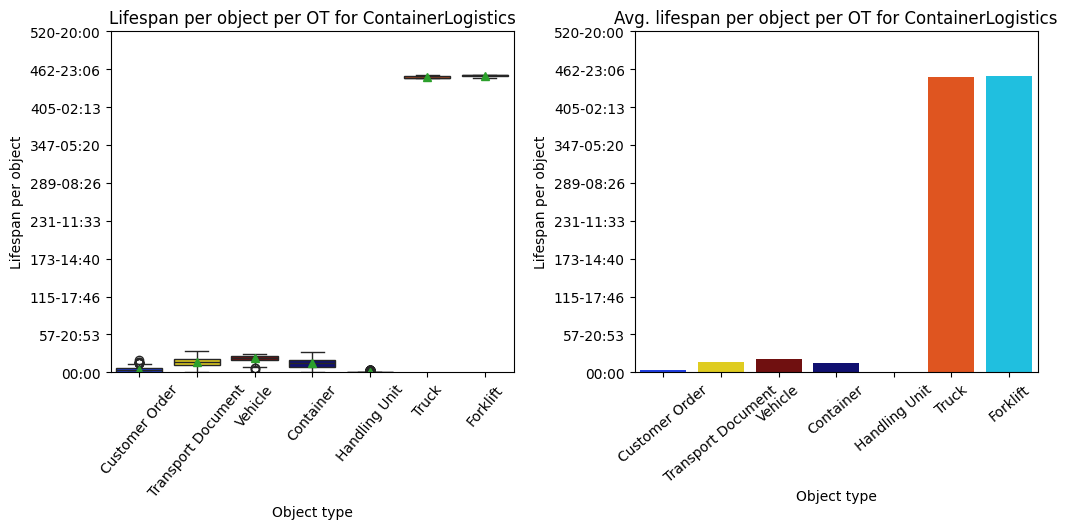

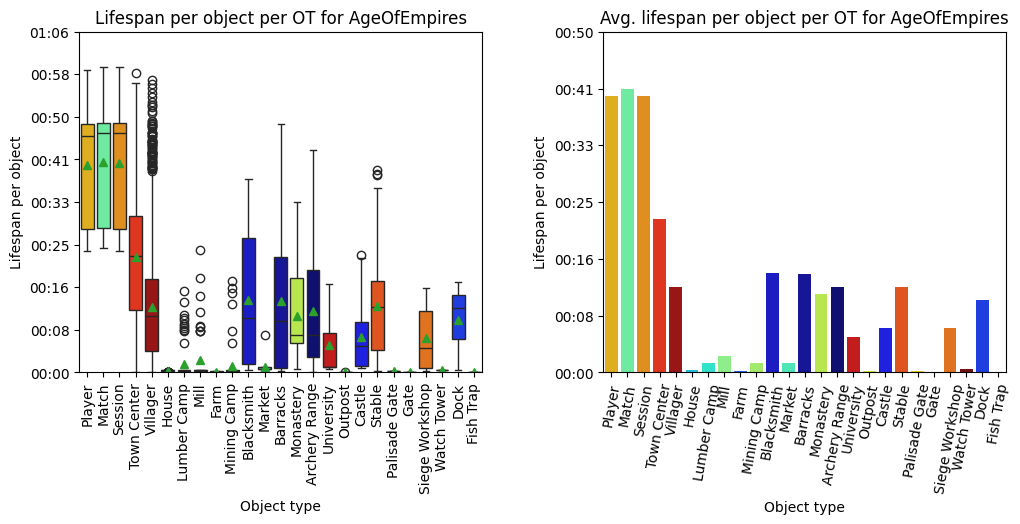

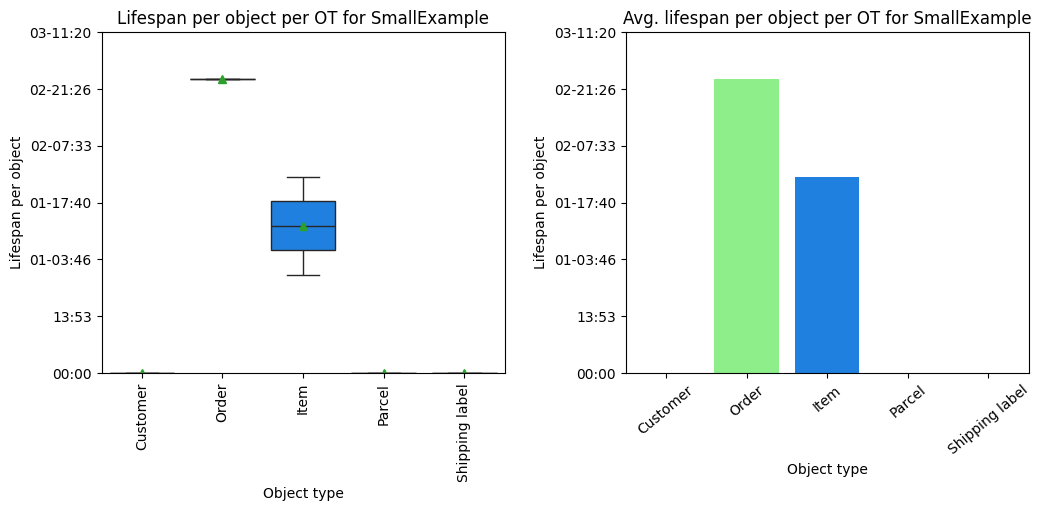

In [25]:
for i, (stream_name, stream) in enumerate([
    ('ContainerLogistics', stream_container_logistics),
    ('AgeOfEmpires', stream_age_of_empires),
    ('SmallExample', stream_example)
    ]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    ls_per_obj, avg_per_ot = ae.get_lifespan(stream)

    ots = sorted(avg_per_ot.keys())
    ot_rgb_colors = cm.jet(np.linspace(0, 1, len(ots)))
    ot_to_rgb_color = dict(zip(ots, ot_rgb_colors))
    
    # Create boxplot to show distribution across entire stream per OT side by side
    sns.boxplot(ls_per_obj, palette=ot_to_rgb_color, ax=axs[0], showmeans=True)
    axs[0].set_title(f'Lifespan per object per OT for {stream_name}')
    axs[0].tick_params(axis='x', rotation=50 if stream_name == 'ContainerLogistics' else 90)
    axs[0].set_ylim(ymin=0)
    axs[0].set_yticks(axs[0].get_yticks())
    axs[0].set_yticklabels([ae.seconds_to_td_str(float(xtl.get_unitless_position()[1])) for xtl in axs[0].get_yticklabels()])
    axs[0].set_xlabel('Object type')
    axs[0].set_ylabel('Lifespan per object')

    # Create barplot of average lifespans per OT
    sns.barplot(x=avg_per_ot.keys(), y=avg_per_ot.values(), hue=avg_per_ot.keys(), palette=ot_to_rgb_color, ax=axs[1])
    axs[1].set_title(f'Avg. lifespan per object per OT for {stream_name}')
    axs[1].tick_params(axis='x', rotation=80 if stream_name == 'AgeOfEmpires' else 40)
    axs[1].set_ylim(ymin=0)
    axs[1].set_yticks(axs[1].get_yticks())
    axs[1].set_yticklabels([ae.seconds_to_td_str(float(xtl.get_unitless_position()[1])) for xtl in axs[1].get_yticklabels()])
    axs[1].set_xlabel('Object type')
    axs[1].set_ylabel('Lifespan per object')